* 아래 함수는 `weather_localcenter_metadata`와 `weather_5minute_ASOS_2020-2023.parquet`, `holiday.csv`를 사용하여 5분 단위 기상대표값을 도출합니다.
* 본 모델링에서는 기상인자로 최고기온, 최저기온, 평균일사량 데이터를 사용하고자 합니다. 일사량의 결측치 비율을 최소화 하기 위해 울산시를 제외한 특별시 및 광역시 데이터를 사용하였으며 (울산시 일사량 데이터의 대부분이 결측치였음), 강원도의 기상 인자도 반영하기 위해 도내에서 가장 인구가 많은 도시인 원주를 포함하였습니다.
* 보간법을 적용하기 전의 기온과 일사량의 결측치 비율은 전체 대비 0.2%, 0.4% 수준이며, 선형보간법을 통해 결측치를 보완하고자 했습니다.
* 단순히 휴일여부가 아니라 어떤 휴일에 해당하는지를 더미변수로 추가해보았습니다. (휴일이 아닌 날, 신정, 설날, 삼일절, 선거일, 어린이날, 석가탄신일, 현충일, 광복절, 추석, 개천절, 기독탄신일, 한글날, 대체공휴일 등 총 14가지로 분류)

In [8]:
import random
import numpy as np
import torch

random_seed = 222
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # multi-GPU

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd 'drive/MyDrive/DL_Proj/'

/content/drive/MyDrive/DL_Proj


In [4]:
def holiday_and_get_dummies(df, holiday_path):

  import pandas as pd

  # 요일 특성 반영 (더미변수로 반영)
  # 0 : 월요일, 1 : 화요일 ~ 금요일, 2 : 토요일, 3 : 일요일

  df['weekday'] = pd.to_datetime(df['datetime']).dt.weekday
  df.replace({'weekday' : {2 : 1, 3 : 1, 4 : 1, 5 : 2, 6 : 3}}, inplace = True)
  df = pd.get_dummies(df, columns = ['weekday'])
                                          
  # 휴일 유형에 맞춘 더미변수 반영

  holiday = pd.read_csv(holiday_path)

  for dateName in ['국회의원선거일', '대통령선거일', '동시지방선거일', '전국동시지방선거', '제21대 국회의원선거']:
    holiday.replace({'dateName' : {dateName : '선거일'}}, inplace = True)
  holiday.replace({'dateName' : {'1월1일' : '신정'}}, inplace = True)
  holiday.replace({'dateName' : {'부처님오신날' : '석가탄신일'}}, inplace = True)
  holiday.replace({'dateName' : {'어린이 날' : '어린이날'}}, inplace = True)
  holiday.replace({'dateName' : {'대체휴무일' : '대체공휴일'}}, inplace = True)
  holiday.replace({'dateName' : {'임시공휴일' : '대체공휴일'}}, inplace = True)

  nameToNumber = {dateName : idx + 1  for idx, dateName in enumerate(list(holiday['dateName'].unique()))}
  holiday.replace({'dateName' : nameToNumber}, inplace = True)
  holiday_dict = {locdate : dateName for dateName, locdate in zip(holiday['dateName'], holiday['locdate'])}

  for row_number in range(df.shape[0]):
    if df.at[row_number, 'datetime'].strftime("%Y-%m-%d") in list(holiday['locdate']):
      df.at[row_number, 'holiday'] = holiday_dict[df.at[row_number, 'datetime'].strftime("%Y-%m-%d")]
    else:
      df.at[row_number, 'holiday'] = 0

  df = pd.get_dummies(df, columns = ['holiday'])

  # 월, 시간 정보 반영 (더미변수로 반영)

  df['month'] = pd.to_datetime(df['datetime']).dt.month
  df = pd.get_dummies(df, columns = ['month'])
  df['hour'] = pd.to_datetime(df['datetime']).dt.hour
  df = pd.get_dummies(df, columns = ['hour'])

  return df

In [5]:
import pandas as pd

target_df = pd.read_parquet('./data/power_demand_moving_avg_added.parquet')[:'2023-03-19'].reset_index()

In [6]:
holiday_path = './data/holidays.csv'
target_df = holiday_and_get_dummies(target_df, holiday_path)

In [7]:
target_df['load'] = target_df['demand']
target_df.drop(columns='demand', inplace=True)
target_df

,datetime,shift_1day,shift_1week,24hour_High,24hour_Low,moving_avg_30min,moving_avg_6hour,moving_avg_1day,moving_avg_1week,moving_avg_4week,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,load
0,2020-01-01 00:00:00,66062.6,67130.9,77636.8,61955.2,66654.600000,67407.618056,68603.534722,65996.575248,67487.682912,...,0,0,0,0,0,0,0,0,0,65340.5
1,2020-01-01 00:05:00,65737.2,66530.0,77636.8,61955.2,66315.266667,67333.652778,68602.001736,65995.962996,67487.607440,...,0,0,0,0,0,0,0,0,0,65295.7
2,2020-01-01 00:10:00,65388.3,66376.3,77636.8,61955.2,65977.333333,67259.123611,68600.996181,65995.329266,67487.537587,...,0,0,0,0,0,0,0,0,0,65098.7
3,2020-01-01 00:15:00,65290.1,66212.6,77636.8,61955.2,65644.816667,67186.227778,68599.736111,65994.691667,67487.471987,...,0,0,0,0,0,0,0,0,0,64927.2
4,2020-01-01 00:20:00,64994.1,65689.9,77636.8,61955.2,65252.616667,67105.980556,68597.953819,65994.091915,67487.369544,...,0,0,0,0,0,0,0,0,0,64480.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338107,2023-03-19 23:35:00,60557.2,60235.2,60868.6,43005.5,59275.150000,59679.415278,52809.317708,62012.021751,64044.231355,...,0,0,0,0,0,0,0,0,1,58627.2
338108,2023-03-19 23:40:00,60279.8,60106.6,60868.6,43005.5,58949.300000,59703.793056,52801.197569,62010.947644,64043.429247,...,0,0,0,0,0,0,0,0,1,57941.2
338109,2023-03-19 23:45:00,60261.0,59725.5,60868.6,43005.5,58675.033333,59721.066667,52792.396181,62009.955928,64042.645468,...,0,0,0,0,0,0,0,0,1,57726.2
338110,2023-03-19 23:50:00,59782.5,59485.6,60868.6,43005.5,58403.216667,59732.433333,52785.357639,62009.097693,64041.883141,...,0,0,0,0,0,0,0,0,1,57755.4


In [ ]:
target_df.columns

Index(['datetime', 'shift_1day', 'shift_1week', '24hour_High', '24hour_Low',
       'moving_avg_30min', 'moving_avg_6hour', 'moving_avg_1day',
       'moving_avg_1week', 'moving_avg_4week', 'moving_avg_12week',
       'moving_avg_6mon', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'holiday_0.0', 'holiday_1.0', 'holiday_2.0', 'holiday_3.0',
       'holiday_4.0', 'holiday_5.0', 'holiday_6.0', 'holiday_7.0',
       'holiday_8.0', 'holiday_9.0', 'holiday_10.0', 'holiday_11.0',
       'holiday_12.0', 'holiday_13.0', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23', 'load'],
      dtype='object')

Custom Dataset과 Dataloader를 사용하여 메모리 사용량을 줄였습니다.

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, target_df, binary_var_start_number, scaler_for_X, scaler_for_Y, seq_len, step_len, stride):
    self.dataset_tensor =torch.FloatTensor(np.array(pd.concat([pd.DataFrame(scaler_for_X.fit_transform(target_df.iloc[:,1:binary_var_start_number])),
                                                               target_df.iloc[:,binary_var_start_number:-1],
                                                               pd.DataFrame(scaler_for_Y.fit_transform(np.array(target_df['load']).reshape(-1, 1)))], axis = 1))).cuda()                           
    self.data_size = ((self.dataset_tensor.shape[0] - step_len - seq_len) // stride) + 1
    self.seq_len = seq_len
    self.step_len = step_len
    self.stride= stride
  
  def __len__(self):
    return self.data_size
  
  def __getitem__(self, idx):
    return self.dataset_tensor[idx*self.stride :idx*self.stride + self.seq_len, :], self.dataset_tensor[idx*self.stride + self.seq_len : idx*self.stride + self.seq_len + self.step_len, -1]

# Scaler 객체 생성
ss_1 = MinMaxScaler() # Scaler for X
ss_2 = MinMaxScaler() # Scaler for y

# CustomDataset 파라미터 설정 (Scaler 객체, 시퀀스의 길이, 스텝 사이즈, 건너뛸 간격)
seq_len = 2016 # 시퀀스의 길이
step_len = 2016 # 스텝 사이즈 (추정하고자 하는 값의 개수)
stride = 1 # 건너뛸 간격

# target_df를 train_df와 test_df로 분리
# target_df는 예측 대상 기간인 2023년 3월 13일부터 19일 + Sequence의 길이만큼의 데이터를 담음
train_df = target_df.iloc[:-8064,:]
valid_df = target_df.iloc[-8064:-2016,:]
test_df = target_df.iloc[-4032:,:]

# 데이터셋 생성
train_dataset = CustomDataset(train_df, 12, ss_1, ss_2, seq_len, step_len, stride)

# 데이터 로더 생성
train_dataloader = DataLoader(train_dataset, batch_size = 256, shuffle = True, drop_last = True)

In [10]:
next(iter(train_dataloader))[0].shape

torch.Size([256, 2016, 66])

In [11]:
import torch.nn as nn

# CNN + 양방향 GRU 모델 구성하기

in_channels = 66 # 입력 컬럼의 개수
out_channels = 132 # 합성곱 필터로 생성될 out의 Dimension = 필터의 개수
hidden_dim = 288 # 은닉 상태의 개수
output_dim = 2016 # 출력 값의 개수(형태)
learning_rate = 0.0001 # 학습률
nb_epochs = 50 # 에포크의 수
seq_length = 2016 # sequence의 길이 (얼마간의 데이터가 들어오는가)

class CNN_BIGRU(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, hidden_dim, seq_len, output_dim, layers):
    super(CNN_BIGRU, self).__init__()
    # 입력인자 정의
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size
    self.hidden_dim = hidden_dim
    self.seq_len = seq_len
    self.output_dim = output_dim
    self.layers = layers
    # 합성곱 Layer 정의
    self.conv1d = nn.Conv1d(in_channels = self.in_channels, 
                            out_channels = self.out_channels,
                            kernel_size = self.kernel_size, 
                            padding = 'same')
    # GRU Layer 정의
    self.lstm = nn.GRU(self.out_channels, 
                       self.hidden_dim, 
                       num_layers = self.layers, 
                       batch_first = True, 
                       bidirectional = True)
    # 완전연결층 정의
    self.fc = nn.Linear(hidden_dim * 2, output_dim, bias = True)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.layers, self.seq_len, self.hidden_dim),
        torch.zeros(self.layers, self.seq_len, self.hidden_dim)
        )
  
  # 결과값 계산
  def forward(self, x):
    x = torch.transpose(x, 1, 2)
    x = self.conv1d(x)
    x = torch.transpose(x, 1, 2)
    x, _status = self.lstm(x)
    x = self.fc(x[:, -1])
    return x

In [12]:
!pip install torchmetrics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 14.2 MB/s eta 0:00:00


In [13]:
# 모델 학습 함수 만들기

# !pip install torchmetrics
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
from torchmetrics import MeanAbsolutePercentageError

def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
  nb_epochs = num_epochs
  mean_abs_percentage_error = MeanAbsolutePercentageError().to(device)

  # epoch마다 loss 저장
  train_hist = np.zeros(nb_epochs)
  output = []
  
  for epoch in range(nb_epochs):
    avg_cost = 0
    total_batch = len(train_df)
    for batch_idx, samples in enumerate(train_df):
      x_train, y_train = samples
      # seq별 hidden state reset
      model.reset_hidden_state()
      # H(x) 계산
      outputs = model(x_train)
      # cost 계산
      loss = mean_abs_percentage_error(outputs, y_train)
      # cost로 H(x) 개선
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      avg_cost += loss/total_batch 

    train_hist[epoch] = avg_cost

    if epoch % verbose == 0:
      print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
    # patience번째 마다 early stopping 여부 확인
    if (epoch % patience == 0) & (epoch != 0):
      if train_hist[epoch-patience] < train_hist[epoch]:
        print('\n Early Stopping')
        break
  
  return model.eval(), train_hist

In [ ]:
# CNN + 양방향 GRU 모델 학습 
# 첫번째 학습
# 커널 사이즈 : 5, GRU layer의 개수 : 3

kernel_size = 5 # 합성곱 필터의 kernel_size

cnn_bigru = CNN_BIGRU(in_channels, out_channels, kernel_size, hidden_dim, seq_len, output_dim, layers = 3).to(device)
cnn_bigru_model_53, cnn_bigru_hist = train_model(cnn_bigru, train_dataloader, num_epochs = nb_epochs,
                                                 lr = learning_rate, verbose = 1, patience = 4)

Epoch: 0000 train loss : 0.4598
Epoch: 0001 train loss : 0.3882
Epoch: 0002 train loss : 0.3409
Epoch: 0003 train loss : 0.2845
Epoch: 0004 train loss : 0.2493
Epoch: 0005 train loss : 0.2255
Epoch: 0006 train loss : 0.2142
Epoch: 0007 train loss : 0.2048
Epoch: 0008 train loss : 0.2431


In [ ]:
torch.save(cnn_bigru_model_53, 'model_20230531_CNN-BIGRU.pth')

In [ ]:
# model validation (CNN + Bidirectional LSTM/GRU)

# 커스텀데이터셋 클래스 정의하기

class CustomDatasetForTest(torch.utils.data.Dataset):
  def __init__(self, target_df, binary_var_start_number, scaler_for_X, scaler_for_Y, seq_len, step_len, stride):
    self.dataset_tensor =torch.FloatTensor(np.array(pd.concat([pd.DataFrame(scaler_for_X.transform(target_df.iloc[:,1:binary_var_start_number])),
                                                               target_df.iloc[:,binary_var_start_number:-1].reset_index(drop = True),
                                                               pd.DataFrame(scaler_for_Y.transform(np.array(target_df['load']).reshape(-1, 1)))], axis = 1))).cuda()                           
    self.data_size = ((self.dataset_tensor.shape[0] - step_len - seq_len) // stride)+1
    self.seq_len = seq_len
    self.step_len = step_len
    self.stride= stride
  
  def __len__(self):
    return self.data_size
  
  def __getitem__(self, idx):
    return self.dataset_tensor[idx*self.stride :idx*self.stride + self.seq_len, :], self.dataset_tensor[idx*self.stride + self.seq_len : idx*self.stride + self.seq_len + self.step_len, -1]

# 데이터셋 및 데이터로더 객체 선언하기

val_dataset = CustomDatasetForTest(valid_df, 12, ss_1, ss_2, seq_len, step_len, stride)
val_dataloader = DataLoader(val_dataset, batch_size = 1, shuffle = False, drop_last = True)

with torch.no_grad():
  
  # 예측값과 실제값을 담을 빈 리스트 준비하기

  cnnbilstm_pred_list_53_val = []
  cnnbigru_pred_list_53_val = []
  true_list = []

  for X, y in val_dataloader:

    # 데이터 로더에서 테스트 데이터 꺼내기
    X = X.to(device)
    y = y.to(device)

    # 모델별 예측값 계산
    lstm_pred_53 = cnn_bilstm_model_53(X)

    # 모델별 예측값 및 실제값을 리스트에 넣어주기
    cnnbilstm_pred_list_53_val.append(ss_2.inverse_transform(lstm_pred_53.cpu().detach().numpy()))
    true_list.append(ss_2.inverse_transform(y.cpu().detach().numpy()))

# 위에서 완성된 예측값, 실제값 리스트로 평균 MAPE 계산하기
cnnbilstm_MAPE_list_53_val = [np.mean(np.abs(pred - true)/true) for pred, true in zip(cnnbilstm_pred_list_53_val, true_list)]

# 모델별 평균 MAPE 출력하기
print('커널 사이즈가 5이고 LSTM Layer가 3개인 CNN + Bi-LSTM 모델의 평균 검증 MAPE는 {}% 입니다'.format(round(sum(cnnbilstm_MAPE_list_53_val)/len(cnnbilstm_MAPE_list_53_val) * 100, 3)))

커널 사이즈가 5이고 LSTM Layer가 3개인 CNN + Bi-LSTM 모델의 평균 검증 MAPE는 4.651% 입니다


In [ ]:
# model TEST (CNN + Bidirectional LSTM/GRU)

# 커스텀데이터셋 클래스 정의하기

class CustomDatasetForTest(torch.utils.data.Dataset):
  def __init__(self, target_df, binary_var_start_number, scaler_for_X, scaler_for_Y, seq_len, step_len, stride):
    self.dataset_tensor =torch.FloatTensor(np.array(pd.concat([pd.DataFrame(scaler_for_X.transform(target_df.iloc[:,1:binary_var_start_number])),
                                                               target_df.iloc[:,binary_var_start_number:-1].reset_index(drop = True),
                                                               pd.DataFrame(scaler_for_Y.transform(np.array(target_df['load']).reshape(-1, 1)))], axis = 1))).cuda()                           
    self.data_size = ((self.dataset_tensor.shape[0] - step_len - seq_len) // stride)+1
    self.seq_len = seq_len
    self.step_len = step_len
    self.stride= stride
  
  def __len__(self):
    return self.data_size
  
  def __getitem__(self, idx):
    return self.dataset_tensor[idx*self.stride :idx*self.stride + self.seq_len, :], self.dataset_tensor[idx*self.stride + self.seq_len : idx*self.stride + self.seq_len + self.step_len, -1]

# 데이터셋 및 데이터로더 객체 선언하기

test_dataset = CustomDatasetForTest(test_df, 12, ss_1, ss_2, seq_len, step_len, stride)
test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle = False, drop_last = True)

with torch.no_grad():
  
  # 예측값과 실제값을 담을 빈 리스트 준비하기

  cnnbilstm_pred_list_53_test = []
  cnnbigru_pred_list_53_test = []
  true_list = []

  for X, y in test_dataloader:

    # 데이터 로더에서 테스트 데이터 꺼내기
    X = X.to(device)
    y = y.to(device)

    # 모델별 예측값 계산
    lstm_pred_53 = cnn_bilstm_model_53(X)

    # 모델별 예측값 및 실제값을 리스트에 넣어주기
    cnnbilstm_pred_list_53_test.append(ss_2.inverse_transform(lstm_pred_53.cpu().detach().numpy()))
    true_list.append(ss_2.inverse_transform(y.cpu().detach().numpy()))

# 위에서 완성된 예측값, 실제값 리스트로 평균 MAPE 계산하기
cnnbilstm_MAPE_list_53_test = [np.mean(np.abs(pred - true)/true) for pred, true in zip(cnnbilstm_pred_list_53_test, true_list)]

# 모델별 평균 MAPE 출력하기
print('커널 사이즈가 5이고 LSTM Layer가 3개인 CNN + Bi-LSTM 모델의 평균 테스트 MAPE는 {}% 입니다'.format(round(sum(cnnbilstm_MAPE_list_53_test)/len(cnnbilstm_MAPE_list_53_test) * 100, 3)))

커널 사이즈가 5이고 LSTM Layer가 3개인 CNN + Bi-LSTM 모델의 평균 테스트 MAPE는 3.263% 입니다


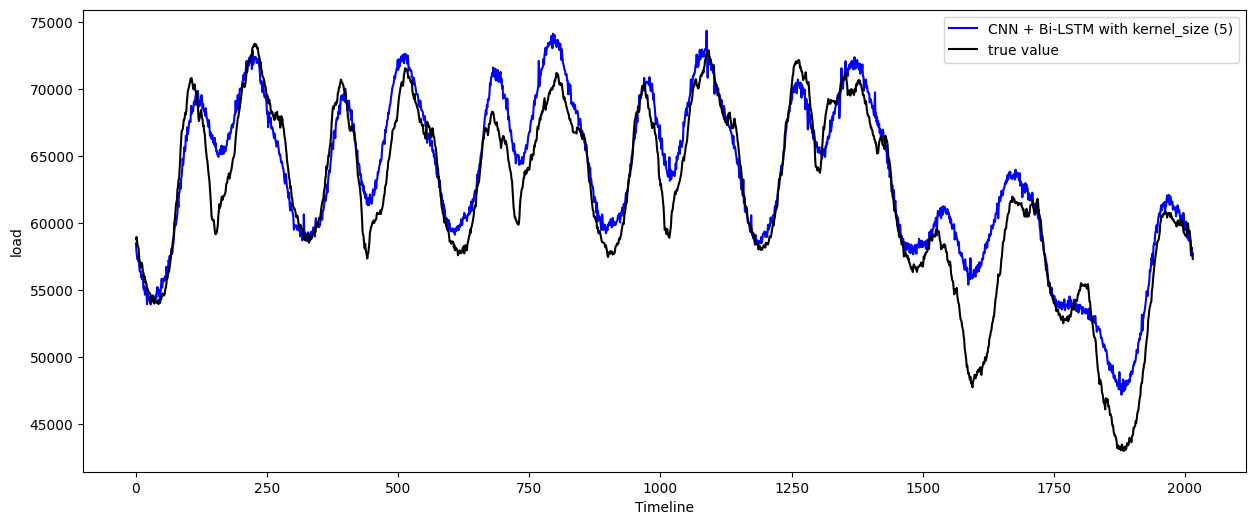

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15,6))
plt.plot(list(cnnbilstm_pred_list_53_test[0][0]), label = 'CNN + Bi-LSTM with kernel_size (5)', color = 'blue')
plt.plot(list(true_list[0][0]), label = 'true value', color = 'black')
plt.xlabel('Timeline')
plt.ylabel('load')
plt.legend()
plt.show()